## Assignment 12

Author: Anjani Bonda<br>
Date: 2023-06-01

In [9]:
# Import required libraries

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
# Define parameters and source image
img_shape = (28,28, 1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding ='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu')(x)

shape_before_flatten = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_var = layers.Dense(latent_dim)(x)

#### Latent space sampling function

In [11]:
def sampling(args):
    z_mean, z_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_var])

#### Map latent space points to images using VAE decoder

In [12]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flatten[1:]), activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flatten[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [13]:
# Check summary
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 12544)             37632     
                                                                 
 reshape_1 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 1)         289       
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_______________________________________________________

#### Compute VAE loss using custom layer

In [14]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        ent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_var - K.square(z_mean) - K.exp(z_var), axis=-1)
        return K.mean(ent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

cvl = CustomVariationalLayer()([input_img, z_decoded])

#### Train MNIST VAE dataset

In [15]:
from keras.datasets import mnist
vae = Model(input_img, cvl)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_6[0][0]']               
                                                                                            

2023-06-03 17:49:49.740213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


60000/60000 [==============================] - ETA: 0s - loss: 0.9691

/Users/anjanibonda/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 301s 5ms/sample - loss: 0.9691 - val_loss: 0.1995
Epoch 2/10
60000/60000 [==============================] - 296s 5ms/sample - loss: 0.1969 - val_loss: 0.1938
Epoch 3/10
60000/60000 [==============================] - 305s 5ms/sample - loss: 0.1921 - val_loss: 0.1905
Epoch 4/10
60000/60000 [==============================] - 304s 5ms/sample - loss: 0.1894 - val_loss: 0.1874
Epoch 5/10
60000/60000 [==============================] - 303s 5ms/sample - loss: 0.1877 - val_loss: 0.1862
Epoch 6/10
60000/60000 [==============================] - 302s 5ms/sample - loss: 0.1865 - val_loss: 0.1855
Epoch 7/10
60000/60000 [==============================] - 302s 5ms/sample - loss: 0.1853 - val_loss: 0.1847
Epoch 8/10
60000/60000 [==============================] - 303s 5ms/sample - loss: 0.1847 - val_loss: 0.1841
Epoch 9/10
60000/60000 [==============================] - 305s 5ms/sample - loss: 0.1842 - val_loss: 0.1847
Epoch 10/10
60000/60000 [==============

#### Sampling grid from 2D latent space and decoding to images

grid_x
[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
grid_y
[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]


/Users/anjanibonda/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


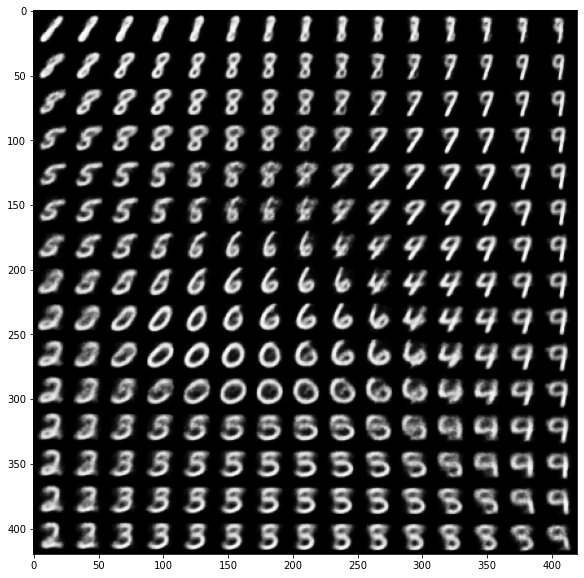

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from pathlib import Path

results_dir = Path('/Users/anjanibonda/Data-Science/DSC650/Week12/results/vae')
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
print("grid_x")
print(grid_x)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print("grid_y")
print(grid_y)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
img_file = results_dir.joinpath('Assignment_12_15x15_Grid.png')
plt.savefig(img_file)
plt.show()